In [2]:
import cv2
import pickle
import os.path
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.utils.training_utils import multi_gpu_model
from keras.layers.convolutional import Conv2D, MaxPooling2D, MaxPooling3D
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers import ConvLSTM2D, BatchNormalization, Activation
import bz2
import gzip
import random
import keras.backend as K

import tensorflow as tf
from keras.engine.training import Model
from keras.engine.topology import Input

from PIL import Image
from sklearn.feature_extraction import image as skimage



Using TensorFlow backend.


In [3]:
MODEL_FILENAME = "preprocess_model.hdf5"
MODEL_LABELS_FILENAME = "preprocess_model.dat"

In [4]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.3
# set_session(tf.Session(config=config))

['y', 'z', 'z', 's', 'g']


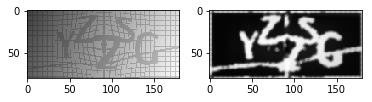

['w', 'e', '4', '6', 'r']


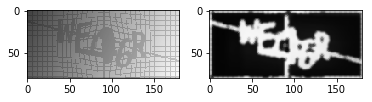

['w', '2', 'e', 'a', 'p']


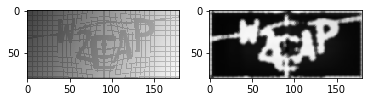

In [5]:
with gzip.open('database_preprocessor1.pkl.gz') as f:
    database = pickle.load(f)

#show some pictures
picts = random.sample(database,3)
for p in picts:
    print(p[0])
    plt.title(''.join(p[0]))
    plt.subplot(1,2,1)
    plt.imshow(Image.fromarray(p[1]))
    plt.subplot(1,2,2)
    plt.imshow(Image.fromarray(p[2]))
    plt.show()

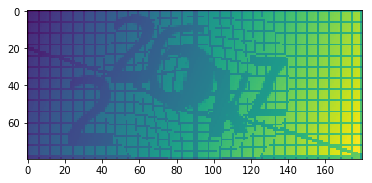

(80, 180)


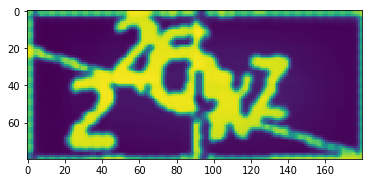

(80, 180)


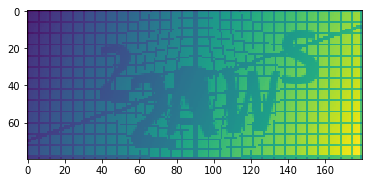

(80, 180)


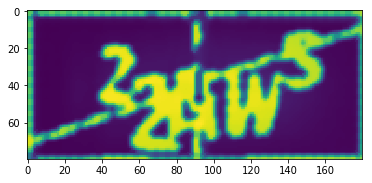

(80, 180)


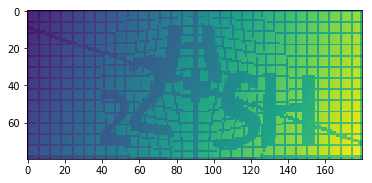

(80, 180)


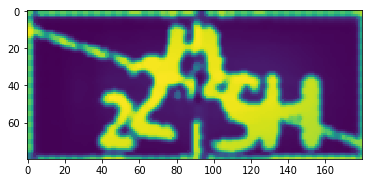

(80, 180)
all_letters: ['e', 'm', 'h', 'p', 'x', 't', 'y', '8', 'a', 's', '2', 'b', 'z', 'r', '3', 'n', '4', '5', '7', 'g', 'f', 'w', 'k', '6']


In [6]:
# initialize the data and labels
data = []
data2 = []
labels = [[], [], [], [], []]
labels2 = []
all_labels_chars = []
plot_first = 0

# loop over the input images
for label, imagein, imageout in database:
    if len(imagein.shape) > 2 and imagein.shape[2] != 1:
        imagein = cv2.cvtColor(imagein, cv2.COLOR_BGR2GRAY)
    
    # Resize the letter so it fits in a 300x50 pixel box
    # image = resize_to_fit(image, 250, 50, 1)

    if plot_first < 3:
        plot_first += 1
        plt.imshow(imagein)
        plt.show()
        print(imagein.shape)
        plt.imshow(imageout)
        plt.show()
        print(imageout.shape)
    
#     Add a third channel dimension to the image to make Keras happy
    imagein = np.expand_dims(imagein, axis=2)
    imageout = np.expand_dims(imageout, axis=2)
    
    if imagein.shape[0] != 80 or imagein.shape[1] != 180 or imagein.shape[2] != 1: 
        print(imagein.shape)
        continue
    if imageout.shape[0] != 80 or imageout.shape[1] != 180 or imageout.shape[2] != 1: 
        print(imageout.shape)
        continue

    all_labels_chars.extend(list(label))
  
    if len(label) < 5 or len(label) > 5:
        print('error:', label)
        continue
  
    # Add the letter image and it's label to our training data
    data.append(imagein)
    data2.append(imageout)
    
    labels2.append(label)
    
    for i in range(5):
        labels[i].append(label[i])

all_labels_chars = set(all_labels_chars)
all_letters = list(all_labels_chars)

print('all_letters:',all_letters)

0.0
1.0
0
1
(80, 180, 1)


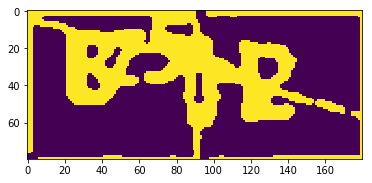

In [7]:
# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = (np.array(data, dtype="float") - np.min(data)) / (np.max(data) - np.min(data))
print(np.min(data))
print(np.max(data))
data2 = np.array(data2) > ((np.max(data2)+np.min(data2))/2)
data2 = np.array(data2,dtype='int')
print(np.min(data2))
print(np.max(data2))

# data2 = (np.array(data2, dtype="float") - np.min(data2)) / (np.max(data2) - np.min(data2))
# print(np.min(data2))
# print(np.max(data2))

labels = np.array(labels)
labels2 = np.array(labels2)

# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, data2, test_size=0.05, random_state=0)

# Split the training data into separate train and test sets
(X_train2, X_test2, Y_train2, Y_test2) = train_test_split(data, labels2, test_size=0.05, random_state=0)

for p in [random.choice(data2)]:
    print(p.shape)
    plt.imshow(p[:,:,0])
    plt.show()
    
lb = [None, None, None, None, None, ]
Y_train3, Y_test3 = [[], [], [], [], []], [[], [], [], [], []]

# Convert the labels (letters) into one-hot encodings that Keras can work with
for j in range(5):
    for i in range(len(Y_train2)):
        Y_train3[j].append(Y_train2[i][j])
    for i in range(len(Y_test)):
        Y_test3[j].append(Y_test2[i][j])
    
    lb[j] = LabelBinarizer().fit(Y_train3[j])
#     lb[j] = LabelBinarizer().fit(all_letters)
    Y_train3[j] = lb[j].transform(Y_train3[j])
    
    Y_test3[j] = lb[j].transform(Y_test3[j])

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

In [8]:
inp = Input((80, 180, 1))

layers = []

layers.append(Conv2D(8, (16, 16), padding="same",
                     input_shape=(80, 180, 1))(inp))
layers.append(BatchNormalization()(layers[-1]))
layers.append(Activation('relu')(layers[-1]))
# layers.append(Dropout(0.4)(layers[-1]))
# layers.append(MaxPooling2D(pool_size=(4, 4), strides=(4, 4))(layers[-1]))

layers.append(Conv2D(16, (16, 16), padding="same")(layers[-1]))
layers.append(Conv2D(16, (16, 16), padding="same")(layers[-1]))
layers.append(Conv2D(16, (16, 16), padding="same")(layers[-1]))
layers.append(BatchNormalization()(layers[-1]))
layers.append(Activation('relu')(layers[-1]))
# layers.append(Dropout(0.4)(layers[-1]))
# layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(layers[-1]))

layers.append(Conv2D(1, (8, 8), padding="same")(layers[-1]))
layers.append(BatchNormalization()(layers[-1]))
layers.append(Activation('relu')(layers[-1]))
# layers.append(Dropout(0.3)(layers[-1]))
# layers.append(MaxPooling2D(pool_size=(1, 1), strides=(1, 1))(layers[-1]))

imagelayer = layers[-1]


layers.append(Conv2D(8, (8, 8), padding="same")(layers[-1]))
layers.append(BatchNormalization()(layers[-1]))
layers.append(Activation('relu')(layers[-1]))
# layers.append(Dropout(0.4)(layers[-1]))
layers.append(MaxPooling2D(pool_size=(4, 4), strides=(4, 4))(layers[-1]))

layers.append(Conv2D(16, (8, 8), padding="same")(layers[-1]))
layers.append(BatchNormalization()(layers[-1]))
layers.append(Activation('relu')(layers[-1]))
# layers.append(Dropout(0.4)(layers[-1]))
layers.append(MaxPooling2D(pool_size=(4, 4), strides=(4, 4))(layers[-1]))


layers.append(Flatten()(layers[-1]))

# layers.append(Dense(128, activation="relu")(layers[-1]))
layers.append(Dense(128)(layers[-1]))
layers.append(BatchNormalization()(layers[-1]))
layers.append(Activation('relu')(layers[-1]))
layers.append(Dropout(0.2)(layers[-1]))
layers.append(Dense(128)(layers[-1]))
layers.append(BatchNormalization()(layers[-1]))
layers.append(Activation('relu')(layers[-1]))
# layers.append(Dense(128, activation="relu")(layers[-1]))
# layers.append(Dense(128, activation="relu")(layers[-1]))

outs = []
outs.append(Dense(len(list(all_letters)), activation="softmax")(layers[-1]))
outs.append(Dense(len(list(all_letters)), activation="softmax")(layers[-1]))
outs.append(Dense(len(list(all_letters)), activation="softmax")(layers[-1]))
outs.append(Dense(len(list(all_letters)), activation="softmax")(layers[-1]))
outs.append(Dense(len(list(all_letters)), activation="softmax")(layers[-1]))

with tf.device('/cpu:0'):
    # Build the neural network!
    single_image_model = Model(inputs=inp, output=imagelayer)
    
# make the model parallel
image_model = single_image_model

print(single_image_model.summary())

# Ask Keras to build the TensorFlow model behind the scenes
image_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


with tf.device('/cpu:0'):
    # Build the neural network!
    single_model = Model(inputs=inp, output=outs)
    
# make the model parallel
model = single_model

print(single_model.summary())

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 180, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 180, 8)        2056      
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 180, 8)        32        
_________________________________________________________________
activation_1 (Activation)    (None, 80, 180, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 180, 16)       32784     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 80, 180, 16)       65552     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 80, 180, 16)       65552     
__________

c:\users\hossein\anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:64: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
c:\users\hossein\anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [11]:
print(Y_train.shape)
print(X_train.shape)
# Train the neural network
image_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=8, epochs=64, verbose=1)

(3005, 80, 180, 1)
(3005, 80, 180, 1)
Train on 3005 samples, validate on 159 samples
Epoch 1/64
3005/3005 [==============================] - 1673s 557ms/step - loss: 0.6479 - acc: 0.7425 - val_loss: 1.7948 - val_acc: 0.6918
Epoch 2/64
   8/3005 [..............................] - ETA: 27:08 - loss: 0.6082 - acc: 0.7480

KeyboardInterrupt: 

In [12]:
# Ask Keras to build the TensorFlow model behind the scenes
single_model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

# Save the trained model to disk
single_model.save(MODEL_FILENAME)

(1, 80, 180, 1)


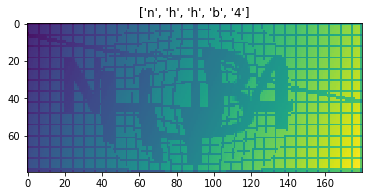

(1, 80, 180, 1)


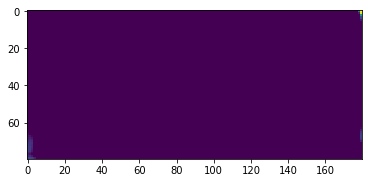

In [13]:
# single_model.load_weights(MODEL_FILENAME)
label, image, imageout = random.choice(database)

# image = np.expand_dims(image, axis=3)
image = np.expand_dims(image[:,:,0:1], axis=0)

pred = single_image_model.predict(image)
# pred_list = lb.inverse_transform(pred[0,:,:])
# print(pred_list)
plt.title(label)
print(image.shape)
plt.imshow(image[0,:,:,0])
plt.show()
print(pred.shape)
plt.imshow(pred[0,:,:,0])
plt.show()

In [69]:
# Train the neural network
model.fit(X_train2, Y_train3[:], validation_data=(X_test2, Y_test3[:]), batch_size=512, epochs=64, verbose=1)

Train on 3005 samples, validate on 159 samples
Epoch 1/64
3005/3005 [==============================] - 7s 2ms/step - loss: 15.8960 - dense_28_loss: 3.1793 - dense_29_loss: 3.1792 - dense_30_loss: 3.1779 - dense_31_loss: 3.1791 - dense_32_loss: 3.1804 - dense_28_acc: 0.0326 - dense_29_acc: 0.0413 - dense_30_acc: 0.0479 - dense_31_acc: 0.0436 - dense_32_acc: 0.0393 - val_loss: 15.8907 - val_dense_28_loss: 3.1793 - val_dense_29_loss: 3.1785 - val_dense_30_loss: 3.1779 - val_dense_31_loss: 3.1768 - val_dense_32_loss: 3.1782 - val_dense_28_acc: 0.0252 - val_dense_29_acc: 0.0377 - val_dense_30_acc: 0.0503 - val_dense_31_acc: 0.0440 - val_dense_32_acc: 0.0503
Epoch 2/64
3005/3005 [==============================] - 4s 1ms/step - loss: 15.8885 - dense_28_loss: 3.1777 - dense_29_loss: 3.1778 - dense_30_loss: 3.1774 - dense_31_loss: 3.1779 - dense_32_loss: 3.1777 - dense_28_acc: 0.0489 - dense_29_acc: 0.0409 - dense_30_acc: 0.0516 - dense_31_acc: 0.0456 - dense_32_acc: 0.0396 - val_loss: 15.8902 

KeyboardInterrupt: 